In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [2]:
IMG_SIZE = 64
NUM_CLASSES = 2  # 0 is background, 1 is defect (bin.)
BASE_DIR = "."
TRAINVAL_FILE = "trainval.txt"
EPOCHS = 50
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "dl_exp_3.pth"

In [3]:
class GradientDefectDataset(Dataset):
    def __init__(self, base_path, file_list_path, img_size):
        with open(file_list_path, "r") as f:
            lines = f.readlines()


        self.images, self.masks = [], []


        for line in lines:
            img_path_rel, ann_path_rel = line.strip().split()
            img_path_full = os.path.join(base_path, img_path_rel.replace(".jpg", "_test.jpg"))
            ann_path_full = os.path.join(base_path, ann_path_rel)

            img = Image.open(img_path_full).convert("RGB")
            orig_size = img.size
            img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
            img_np = np.array(img, dtype=np.float32) / 255.0

            gray = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
            grad_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
            grad = np.sqrt(grad_x**2 + grad_y**2)
            grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-8)
            grad = np.stack([grad]*3, axis=2)
            self.images.append(grad.astype(np.float32))

            mask = np.zeros((img_size, img_size), dtype=np.int64)
            scale_x, scale_y = img_size / orig_size[0], img_size / orig_size[1]

            with open(ann_path_full, "r") as f_ann:
                for l in f_ann:
                    parts = l.strip().split()
                    if len(parts) < 5:
                        continue
                    x1, y1, x2, y2, class_id = map(int, parts)
                    if class_id == 0:
                        continue
                    nx1, ny1 = max(0, int(x1 * scale_x)), max(0, int(y1 * scale_y))
                    nx2, ny2 = min(img_size - 1, int(x2 * scale_x)), min(img_size - 1, int(y2 * scale_y))
                    if ny1 < ny2 and nx1 < nx2:
                        mask[ny1:ny2, nx1:nx2] = 1
            self.masks.append(mask)


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx].transpose(2, 0, 1), dtype=torch.float32)
        mask = torch.tensor(self.masks[idx], dtype=torch.long)
        return img, mask

In [4]:
class ResNetBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)


        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_c, out_c, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )


    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out


class ResUNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Encoder Path
        self.enc1 = ResNetBlock(3, 64)
        self.enc2 = ResNetBlock(64, 128, stride=2)
        self.enc3 = ResNetBlock(128, 256, stride=2)
        self.enc4 = ResNetBlock(256, 512, stride=2)


        # Bottleneck
        self.bottleneck = ResNetBlock(512, 1024, stride=2)


        # Decoder Path
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec1 = ResNetBlock(1024, 512) # Concat: 512(up) + 512(enc4)


        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = ResNetBlock(512, 256) # Concat: 256(up) + 256(enc3)


        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = ResNetBlock(256, 128) # Concat: 128(up) + 128(enc2)


        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec4 = ResNetBlock(128, 64)   # Concat: 64(up) + 64(enc1)


        # Final Output
        self.out_conv = nn.Conv2d(64, num_classes, 1)


    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        c2 = self.enc2(c1)
        c3 = self.enc3(c2)
        c4 = self.enc4(c3)
        
        # Bottleneck
        b = self.bottleneck(c4)
        
        # Decoder
        u1 = self.up1(b)
        u1 = torch.cat([u1, c4], dim=1)
        d1 = self.dec1(u1)


        u2 = self.up2(d1)
        u2 = torch.cat([u2, c3], dim=1)
        d2 = self.dec2(u2)


        u3 = self.up3(d2)
        u3 = torch.cat([u3, c2], dim=1)
        d3 = self.dec3(u3)
        
        u4 = self.up4(d3)
        u4 = torch.cat([u4, c1], dim=1)
        d4 = self.dec4(u4)
        
        return self.out_conv(d4)

In [5]:
def pixel_accuracy(preds, masks):
    return (preds == masks).sum().item() / masks.numel()

def display_results(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss")


    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.title("Pixel Accuracy")


    plt.show()


def display_prediction(image, true_mask, pred_mask):
    plt.figure(figsize=(15, 5))


    plt.subplot(1, 3, 1)
    plt.imshow(image.transpose(1, 2, 0))
    plt.title("Input Image")


    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title("True Mask")


    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")


    plt.show()

Epoch [1/50] Train Loss: 0.3110, Train Acc: 0.9022 | Val Loss: 0.1942, Val Acc: 0.9762


Epoch [2/50] Train Loss: 0.1180, Train Acc: 0.9759 | Val Loss: 0.1003, Val Acc: 0.9762


Epoch [3/50] Train Loss: 0.0911, Train Acc: 0.9770 | Val Loss: 0.0864, Val Acc: 0.9773


Epoch [4/50] Train Loss: 0.0769, Train Acc: 0.9792 | Val Loss: 0.0753, Val Acc: 0.9784


Epoch [5/50] Train Loss: 0.0716, Train Acc: 0.9798 | Val Loss: 0.0678, Val Acc: 0.9809


Epoch [6/50] Train Loss: 0.0653, Train Acc: 0.9809 | Val Loss: 0.0608, Val Acc: 0.9820


Epoch [7/50] Train Loss: 0.0627, Train Acc: 0.9809 | Val Loss: 0.0626, Val Acc: 0.9813


Epoch [8/50] Train Loss: 0.0589, Train Acc: 0.9819 | Val Loss: 0.0579, Val Acc: 0.9825


Epoch [9/50] Train Loss: 0.0552, Train Acc: 0.9828 | Val Loss: 0.0565, Val Acc: 0.9827


Epoch [10/50] Train Loss: 0.0518, Train Acc: 0.9836 | Val Loss: 0.0572, Val Acc: 0.9817


Epoch [11/50] Train Loss: 0.0480, Train Acc: 0.9845 | Val Loss: 0.0552, Val Acc: 0.9833


Epoch [12/50] Train Loss: 0.0436, Train Acc: 0.9856 | Val Loss: 0.0634, Val Acc: 0.9791


Epoch [13/50] Train Loss: 0.0411, Train Acc: 0.9861 | Val Loss: 0.0598, Val Acc: 0.9817


Epoch [14/50] Train Loss: 0.0375, Train Acc: 0.9870 | Val Loss: 0.0591, Val Acc: 0.9833


Epoch [15/50] Train Loss: 0.0336, Train Acc: 0.9881 | Val Loss: 0.0558, Val Acc: 0.9835


Epoch [16/50] Train Loss: 0.0302, Train Acc: 0.9891 | Val Loss: 0.0543, Val Acc: 0.9827


Epoch [17/50] Train Loss: 0.0266, Train Acc: 0.9903 | Val Loss: 0.0626, Val Acc: 0.9831


Epoch [18/50] Train Loss: 0.0245, Train Acc: 0.9910 | Val Loss: 0.0566, Val Acc: 0.9827


Epoch [19/50] Train Loss: 0.0212, Train Acc: 0.9921 | Val Loss: 0.0584, Val Acc: 0.9829


Epoch [20/50] Train Loss: 0.0189, Train Acc: 0.9929 | Val Loss: 0.0624, Val Acc: 0.9837


Epoch [21/50] Train Loss: 0.0169, Train Acc: 0.9937 | Val Loss: 0.0639, Val Acc: 0.9837


Epoch [22/50] Train Loss: 0.0151, Train Acc: 0.9944 | Val Loss: 0.0672, Val Acc: 0.9833


Epoch [23/50] Train Loss: 0.0137, Train Acc: 0.9950 | Val Loss: 0.0648, Val Acc: 0.9829


Epoch [24/50] Train Loss: 0.0121, Train Acc: 0.9956 | Val Loss: 0.0722, Val Acc: 0.9842


Epoch [25/50] Train Loss: 0.0102, Train Acc: 0.9964 | Val Loss: 0.0695, Val Acc: 0.9837


Epoch [26/50] Train Loss: 0.0088, Train Acc: 0.9969 | Val Loss: 0.0724, Val Acc: 0.9839


Epoch [27/50] Train Loss: 0.0073, Train Acc: 0.9975 | Val Loss: 0.0757, Val Acc: 0.9833


Epoch [28/50] Train Loss: 0.0069, Train Acc: 0.9977 | Val Loss: 0.0837, Val Acc: 0.9843


Epoch [29/50] Train Loss: 0.0057, Train Acc: 0.9981 | Val Loss: 0.0799, Val Acc: 0.9831


Epoch [30/50] Train Loss: 0.0048, Train Acc: 0.9985 | Val Loss: 0.0807, Val Acc: 0.9840


Epoch [31/50] Train Loss: 0.0043, Train Acc: 0.9986 | Val Loss: 0.0829, Val Acc: 0.9836


Epoch [32/50] Train Loss: 0.0037, Train Acc: 0.9989 | Val Loss: 0.0807, Val Acc: 0.9842


Epoch [33/50] Train Loss: 0.0032, Train Acc: 0.9991 | Val Loss: 0.0846, Val Acc: 0.9839


Epoch [34/50] Train Loss: 0.0026, Train Acc: 0.9993 | Val Loss: 0.0872, Val Acc: 0.9842


Epoch [35/50] Train Loss: 0.0024, Train Acc: 0.9993 | Val Loss: 0.0876, Val Acc: 0.9839


Epoch [36/50] Train Loss: 0.0021, Train Acc: 0.9994 | Val Loss: 0.0894, Val Acc: 0.9839


Epoch [37/50] Train Loss: 0.0017, Train Acc: 0.9996 | Val Loss: 0.0908, Val Acc: 0.9839


Epoch [38/50] Train Loss: 0.0015, Train Acc: 0.9996 | Val Loss: 0.0933, Val Acc: 0.9833


Epoch [39/50] Train Loss: 0.0013, Train Acc: 0.9997 | Val Loss: 0.0957, Val Acc: 0.9840


Epoch [40/50] Train Loss: 0.0017, Train Acc: 0.9995 | Val Loss: 0.0919, Val Acc: 0.9840


Epoch [41/50] Train Loss: 0.0018, Train Acc: 0.9995 | Val Loss: 0.0971, Val Acc: 0.9842


Epoch [42/50] Train Loss: 0.0015, Train Acc: 0.9996 | Val Loss: 0.1007, Val Acc: 0.9840


Epoch [43/50] Train Loss: 0.0016, Train Acc: 0.9996 | Val Loss: 0.0953, Val Acc: 0.9838


Epoch [44/50] Train Loss: 0.0015, Train Acc: 0.9995 | Val Loss: 0.0966, Val Acc: 0.9840


Epoch [45/50] Train Loss: 0.0017, Train Acc: 0.9995 | Val Loss: 0.1014, Val Acc: 0.9841


Epoch [46/50] Train Loss: 0.0020, Train Acc: 0.9994 | Val Loss: 0.0984, Val Acc: 0.9835


Epoch [47/50] Train Loss: 0.0022, Train Acc: 0.9993 | Val Loss: 0.0956, Val Acc: 0.9837


Epoch [48/50] Train Loss: 0.0016, Train Acc: 0.9995 | Val Loss: 0.0989, Val Acc: 0.9841


Epoch [49/50] Train Loss: 0.0012, Train Acc: 0.9997 | Val Loss: 0.0966, Val Acc: 0.9840


Epoch [50/50] Train Loss: 0.0009, Train Acc: 0.9998 | Val Loss: 0.0971, Val Acc: 0.9839
Final model saved to dl_exp_3.pth


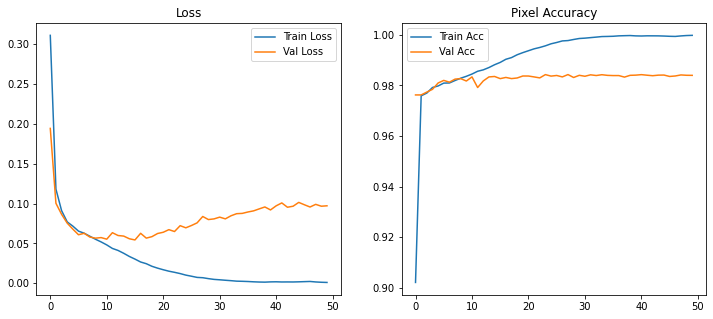

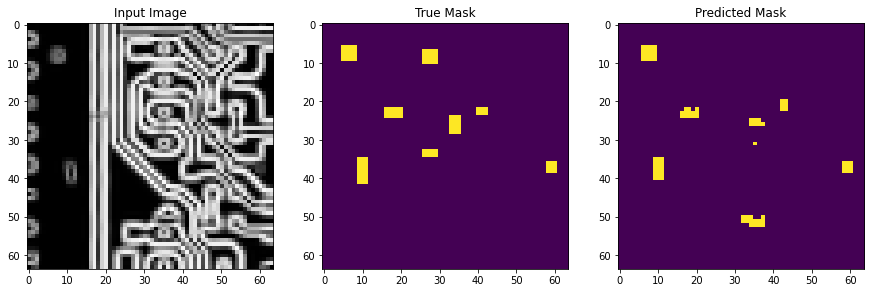

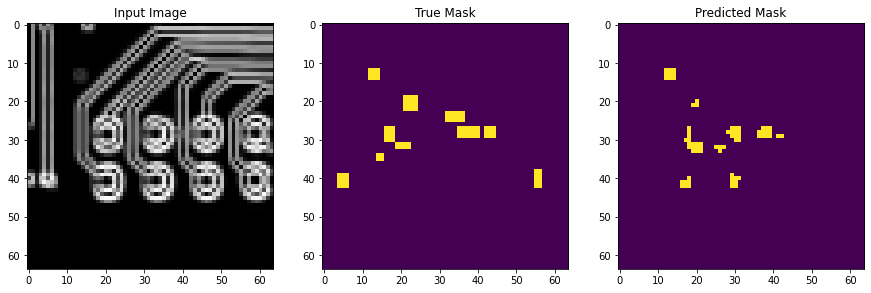

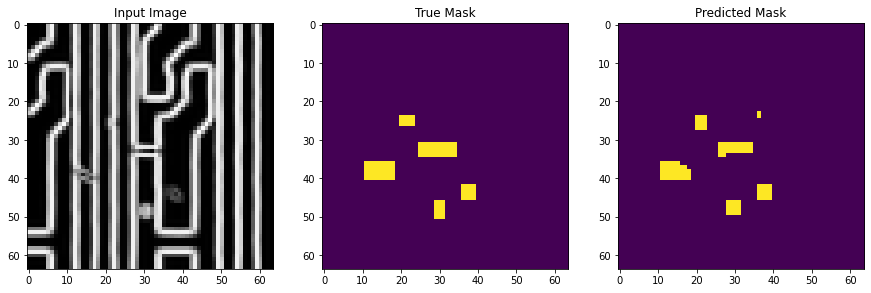

In [6]:
if __name__ == "__main__":
    dataset = GradientDefectDataset(BASE_DIR, TRAINVAL_FILE, IMG_SIZE)
    n_val = int(0.2 * len(dataset))
    n_train = len(dataset) - n_val


    train_set, val_set = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)


    model = ResUNet(NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()


    train_losses, val_losses, train_accs, val_accs = [], [], [], []


    for epoch in range(EPOCHS):
        model.train()
        running_loss, running_acc = 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)


        for imgs, masks in loop:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)


            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)


            loss.backward()
            optimizer.step()


            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            acc = pixel_accuracy(preds, masks)
            running_acc += acc


            loop.set_postfix(loss=loss.item(), acc=acc)


        train_losses.append(running_loss / len(train_loader))
        train_accs.append(running_acc / len(train_loader))


        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, masks)


                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_acc += pixel_accuracy(preds, masks)


        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc / len(val_loader))


        print(
            f"Epoch [{epoch+1}/{EPOCHS}] "
            f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
            f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}"
        )

    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Final model saved to {MODEL_PATH}")

    display_results(train_losses, val_losses, train_accs, val_accs)
    
    sample_imgs, sample_masks = next(iter(val_loader))
    sample_imgs = sample_imgs.to(DEVICE)
    with torch.no_grad():
        preds = torch.argmax(model(sample_imgs), dim=1).cpu().numpy()


    for i in range(min(3, len(sample_imgs))):
        display_prediction(sample_imgs[i].cpu().numpy(), sample_masks[i].numpy(), preds[i])